In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [2]:
C1_ch0 = pd.read_csv('/Users/emiliebertholet/cernbox/coldbox_data/LED/C1_HDconnectedBiased/C1_Apr112024_6p2V_500Hz_HDconnectedBiased_EP106_VGAIN0p4_offset1062_OIsOFF_channel0_AFE0.csv', delimiter=' ')
print(C1_ch0.shape)

C1_ch7 = pd.read_csv('/Users/emiliebertholet/cernbox/coldbox_data/LED/C1_HDconnectedBiased/C1_Apr112024_6p2V_500Hz_HDconnectedBiased_EP106_VGAIN0p4_offset1058_OIsOFF_channel7_AFE0.csv', delimiter=' ')
print(C1_ch7.shape)


(9999, 1000)
(9999, 1000)


In [3]:
C1_ch0.head()

,2076,2073,2072,2073.1,2068,2069,2071,2067,2065,2064,...,2066.64,2062.50,2062.51,2066.65,2062.52,2065.68,2067.56,2064.59,2061.50,2065.69
0,2073,2066,2065,2070,2072,2073,2070,2069,2070,2073,...,2104,2101,2111,2113,2104,2103,2099,2101,2105,2104
1,2040,2042,2044,2042,2044,2039,2039,2038,2041,2042,...,2042,2042,2047,2048,2042,2043,2048,2039,2038,2038
2,2066,2067,2066,2063,2063,2066,2063,2065,2063,2069,...,2067,2070,2067,2065,2063,2064,2067,2061,2067,2069
3,2110,2110,2112,2109,2111,2114,2112,2115,2113,2110,...,2048,2051,2051,2050,2054,2054,2050,2047,2052,2055
4,2065,2062,2065,2065,2065,2065,2069,2069,2067,2065,...,1977,1976,1970,1966,1963,1962,1961,1959,1955,1953


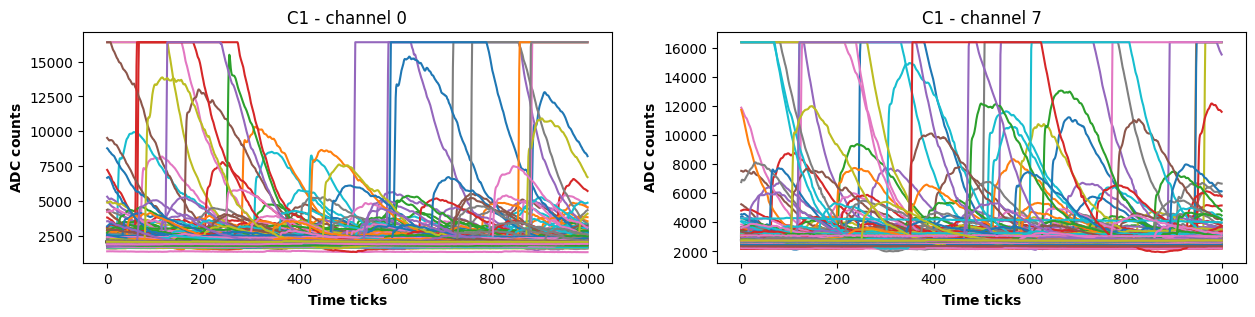

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))

evts = range(0, 9999)

ax = axs.flatten()[0]
for i in evts:
    ax.plot(np.arange(0, 1000, 1), C1_ch0.iloc[i].transpose())
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
ax.set_title(r"C1 - channel 0");

ax = axs.flatten()[1]
for i in evts:
    ax.plot(np.arange(0, 1000, 1), C1_ch7.iloc[i].transpose())
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
ax.set_title(r"C1 - channel 7");





# Remove saturated waveforms

In [5]:
# get the max of the 2d array
C1_ch0.max().max()

np.int64(16383)

ADCsat for ch0 = 16383
ADCsat for ch7 = 16383


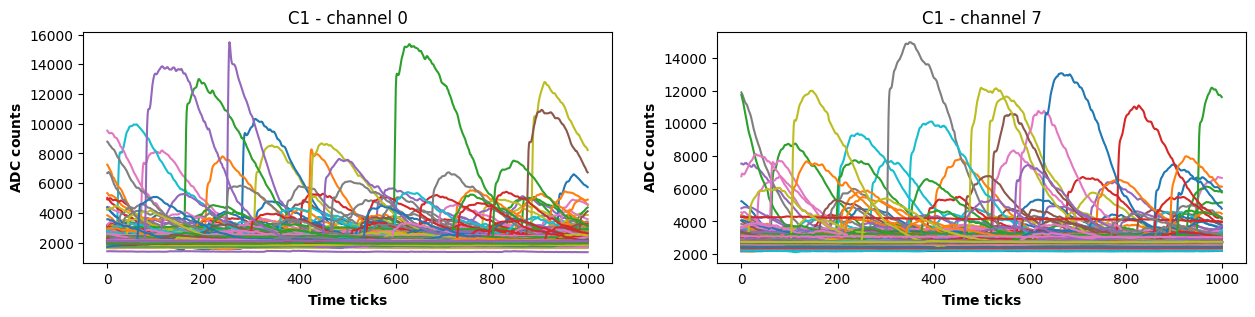

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))

evts = range(0, 9999)

print(f'ADCsat for ch0 = {C1_ch0.max().max()}')
print(f'ADCsat for ch7 = {C1_ch7.max().max()}')

ax = axs.flatten()[0]
for i in evts:
    if C1_ch0.iloc[i].max()<C1_ch0.max().max():
        ax.plot(np.arange(0, 1000, 1), C1_ch0.iloc[i].transpose())
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
ax.set_title(r"C1 - channel 0");

ax = axs.flatten()[1]
for i in evts:
    if C1_ch7.iloc[i].max()<C1_ch7.max().max():
        ax.plot(np.arange(0, 1000, 1), C1_ch7.iloc[i].transpose())
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
ax.set_title(r"C1 - channel 7");





In [7]:
np.array(C1_ch0)

array([[2073, 2066, 2065, ..., 2101, 2105, 2104],
       [2040, 2042, 2044, ..., 2039, 2038, 2038],
       [2066, 2067, 2066, ..., 2061, 2067, 2069],
       ...,
       [1920, 1926, 1926, ..., 1948, 1945, 1948],
       [2092, 2087, 2085, ..., 2091, 2090, 2093],
       [2100, 2096, 2100, ..., 2097, 2089, 2092]], shape=(9999, 1000))

In [8]:
def remove_saturated_wfs(channel):
    ch = np.array(channel)
    clean = []
    for row in ch:
        if row.max()<ch.max().max():
            clean.append(row)
        else: 
            clean.append(np.zeros_like(row))
    return np.array(clean)
            
    

In [9]:
ch0_clean = remove_saturated_wfs(C1_ch0)
ch7_clean = remove_saturated_wfs(C1_ch7)

In [10]:
ch0_clean[505:510]

array([[2036, 2030, 2033, ..., 2031, 2033, 2030],
       [2073, 2078, 2078, ..., 2039, 2040, 2041],
       [2060, 2061, 2060, ..., 2044, 2043, 2046],
       [   0,    0,    0, ...,    0,    0,    0],
       [2010, 2008, 2006, ..., 1984, 1986, 1987]], shape=(5, 1000))

# Pedestal subtraction

In [11]:
def substract_pedestals(array_2d):
    subtracted, pedestals = [], []
    for row in array_2d:
        pedestal = np.argmax(np.bincount(row))
        subtracted.append(row - pedestal)
        pedestals.append(pedestal)
    return np.array(subtracted), np.array(pedestals)

In [12]:
C1_ch0_ped, C1_ch0_pedestals = substract_pedestals(ch0_clean)
C1_ch7_ped, C1_ch7_pedestals = substract_pedestals(ch7_clean)

In [13]:
C1_ch0_ped.shape

(9999, 1000)

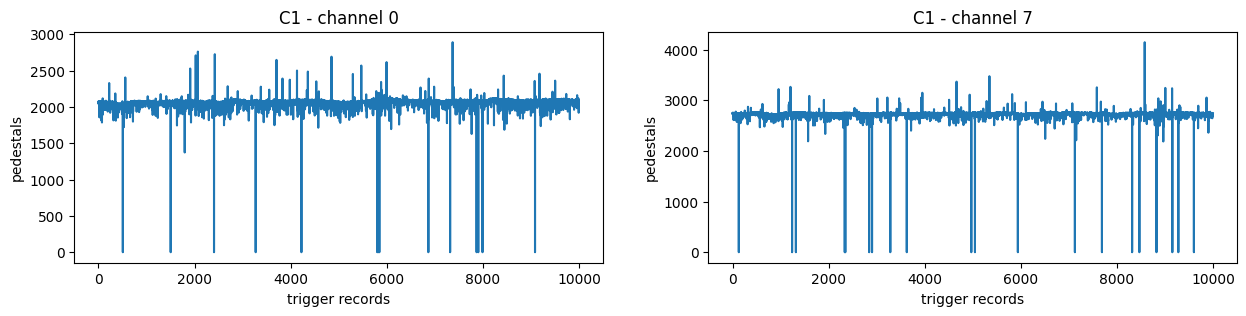

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))

ax = axs.flatten()[0]
ax.plot(np.arange(0, C1_ch0_ped.shape[0], 1), C1_ch0_pedestals)
ax.set_xlabel(r"trigger records")
ax.set_ylabel(r"pedestals");
ax.set_title(r"C1 - channel 0");
# ax.set_xlim(500, 510)

ax = axs.flatten()[1]
ax.plot(np.arange(0, C1_ch7_ped.shape[0], 1), C1_ch7_pedestals)
ax.set_xlabel(r"trigger records")
ax.set_ylabel(r"pedestals");
ax.set_title(r"C1 - channel 7");

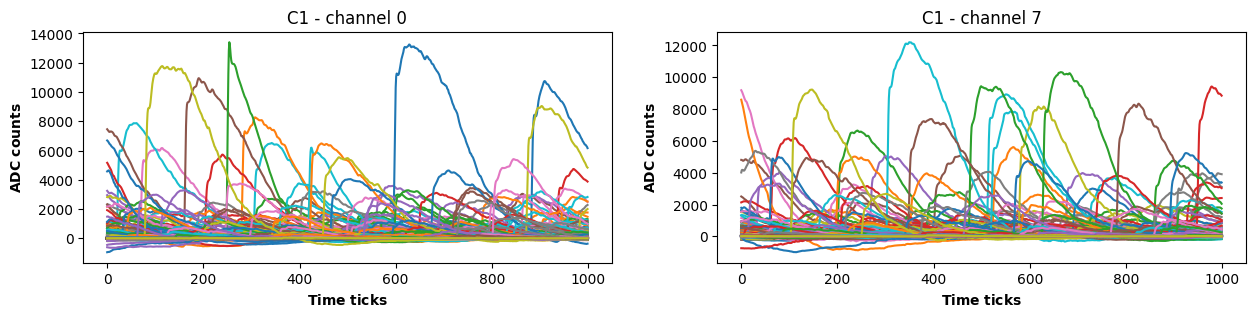

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))

# evts = range(0, 9999)

ax = axs.flatten()[0]
for i in range(0, C1_ch0_ped.shape[0]):
    ax.plot(np.arange(0, C1_ch0_ped.shape[1], 1), C1_ch0_ped[i].transpose())
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
ax.set_title(r"C1 - channel 0");

ax = axs.flatten()[1]
for i in range(0, C1_ch7_ped.shape[0]):
    ax.plot(np.arange(0, C1_ch7_ped.shape[1], 1), C1_ch7_ped[i].transpose())
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
ax.set_title(r"C1 - channel 7");





# Align waveforms (find peaks)

In [16]:
from scipy.signal import find_peaks

def find_peaks_2d(array_2d, **kwargs):
    props_list = []
    peak_indices = []
    peak_heights = []
    flat_peak_indices = []
    peak_slices = []

    for row_idx, row in enumerate(array_2d):
        peaks, props = find_peaks(row, **kwargs)
        heights = props.get("peak_heights", row[peaks])

        # Get slices using left_ips and right_ips (only if width is calculated)
        slices = []
        left_ips = props.get("left_ips")
        right_ips = props.get("right_ips")
        if left_ips is not None and right_ips is not None:
            for l, r in zip(left_ips, right_ips):
                # Convert fractional indices to integers (rounding)
                start = max(0, int(np.floor(l)))
                end = min(len(row), int(np.ceil(r)))
                slices.append(row[start:end])
        else:
            slices = [row[p] for p in peaks]  # fallback: just the peak point

        props_list.append(props)
        peak_indices.append(peaks)
        peak_heights.append(heights)
        flat_peak_indices.extend([(row_idx, col) for col in peaks])
        peak_slices.append(slices)


    return {
        "peak_indices_2d": peak_indices,
        "peak_heights": peak_heights,
        "properties": props_list,
        "waveforms": peak_slices,
        "flat_peak_indices": flat_peak_indices
    }


In [17]:
ch0_dict = find_peaks_2d(C1_ch0_ped, height=None, distance=100, 
                                        prominence=100, rel_height=0.9, wlen=None,  
                                        plateau_size=0, width=0 )
ch0_dict["pedestals"] = C1_ch0_pedestals 

ch7_dict = find_peaks_2d(C1_ch7_ped, height=None, distance=100, 
                                        prominence=100, rel_height=0.9, wlen=None,  
                                        plateau_size=0, width=0 )
ch7_dict["pedestals"] = C1_ch7_pedestals 


In [18]:
ch0_dict.keys()

dict_keys(['peak_indices_2d', 'peak_heights', 'properties', 'waveforms', 'flat_peak_indices', 'pedestals'])

In [19]:
len( ch0_dict['waveforms'] )

9999

In [20]:
def flatten_wfs(wf_dict):
    wfs = wf_dict['waveforms']
    wfs_flat = []
    for i in range(0, len(wfs)):
        if len(wfs[i])>1:
            for j in range(0, len(wfs[i])):
                wf = np.array(wfs[i][j])
                if wf.shape[0]>0:
                    wfs_flat.append(wf)
        else:
            wf = np.array(wfs[i])
            if wf.shape[0]>0:
                wfs_flat.append(wf.reshape(wf.shape[1]))
    return wfs_flat


In [21]:
wfs_flat = flatten_wfs(ch0_dict)
ch0_dict['wfs_flat'] = wfs_flat

wfs_flat = flatten_wfs(ch7_dict)
ch7_dict['wfs_flat'] = wfs_flat


In [22]:
def pad_waveforms(input_data, pad_length=500, var='wfs_flat'):
    output_data = input_data
    output_data['wfs_padded'] = [np.pad(wf, (0, pad_length - len(wf))) if len(wf) < pad_length else wf[:pad_length] for wf in output_data[var]]
    return output_data

ch0_dict = pad_waveforms(ch0_dict, pad_length=1000)
ch7_dict = pad_waveforms(ch7_dict, pad_length=1000)

In [23]:
def plot_wfs(wfs, evts, ax):
    # plot from the 2d waveforms
    for i in evts:
        if len(wfs[i])>1:
            for j in range(0, len(wfs[i])):
                wf = np.array(wfs[i][j])
                if wf.shape[0]>0:
                    ax.plot(np.arange(0, wf.shape[0], 1), wf.transpose());
        else:
            wf = np.array(wfs[i])
            if wf.shape[0]>0:
                ax.plot(np.arange(0, wf.shape[1], 1), wf.transpose());



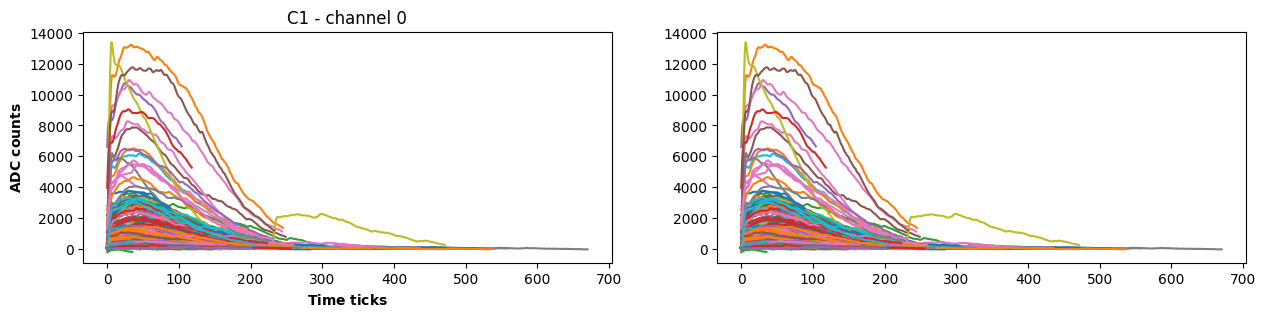

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))

evts = range(0, 9999)

ax = axs.flatten()[0]
plot_wfs(ch0_dict['waveforms'], evts, ax)
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
ax.set_title(r"C1 - channel 0");

ax = axs.flatten()[1]

for i in range(0, len(ch0_dict['wfs_flat'])):
    wf = ch0_dict['wfs_flat'][i]
    ax.plot(np.arange(0, wf.shape[0], 1), wf);


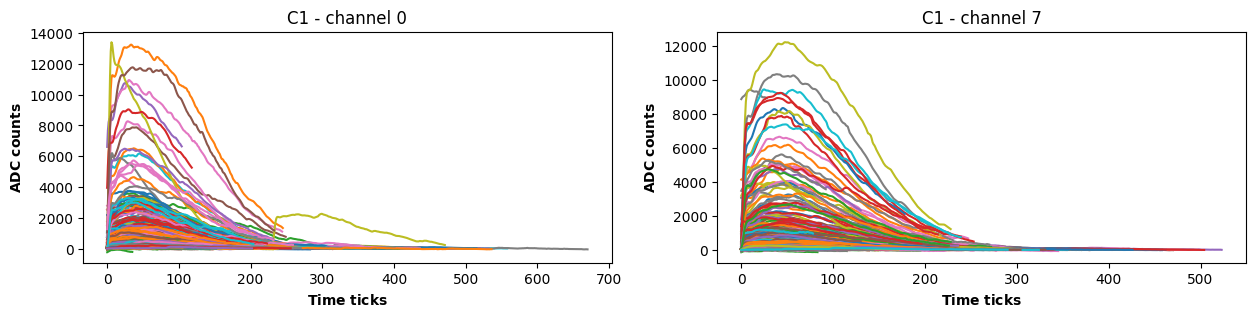

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))

evts = range(0, 9999)

ax = axs.flatten()[0]
for i in range(0, len(ch0_dict['wfs_flat'])):
    wf = ch0_dict['wfs_flat'][i]
    ax.plot(np.arange(0, wf.shape[0], 1), wf);
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
ax.set_title(r"C1 - channel 0");

ax = axs.flatten()[1]

for i in range(0, len(ch7_dict['wfs_flat'])):
    wf = ch7_dict['wfs_flat'][i]
    ax.plot(np.arange(0, wf.shape[0], 1), wf);
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
ax.set_title(r"C1 - channel 7");

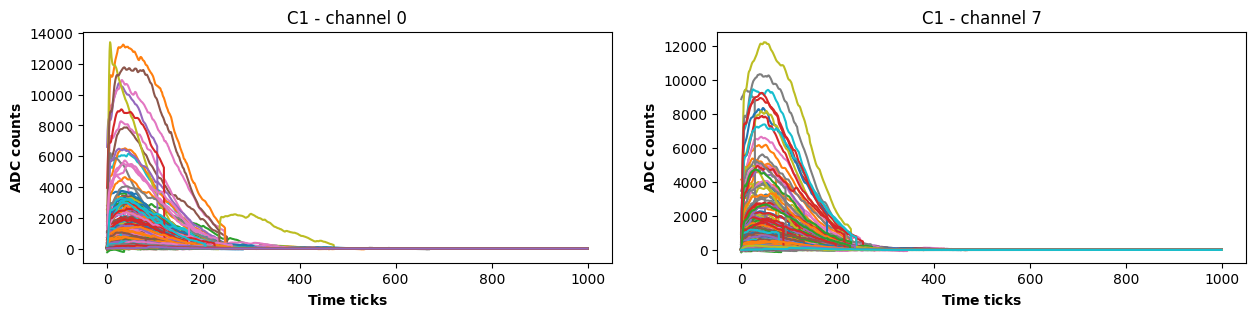

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))

evts = range(0, 9999)

ax = axs.flatten()[0]
for i in range(0, len(ch0_dict['wfs_padded'])):
    wf = ch0_dict['wfs_padded'][i]
    ax.plot(np.arange(0, wf.shape[0], 1), wf);
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
ax.set_title(r"C1 - channel 0");

ax = axs.flatten()[1]

for i in range(0, len(ch7_dict['wfs_padded'])):
    wf = ch7_dict['wfs_padded'][i]
    ax.plot(np.arange(0, wf.shape[0], 1), wf);
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
ax.set_title(r"C1 - channel 7");

# Compute Averaged Waveform

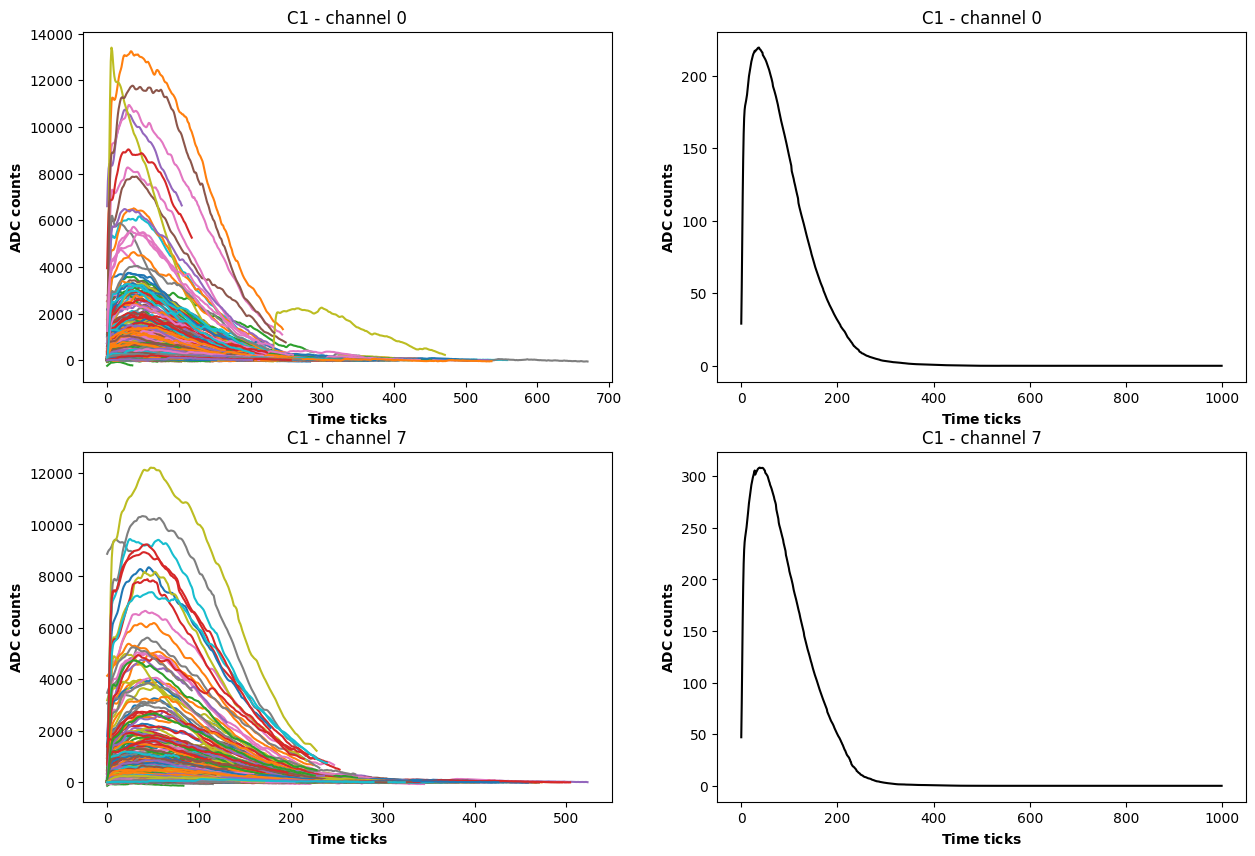

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

evts = range(0, 1000)

ax = axs.flatten()[0]
for i in range(0, len(ch0_dict['wfs_flat'])):
    wf = ch0_dict['wfs_flat'][i]
    ax.plot(np.arange(0, wf.shape[0], 1), wf);
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
ax.set_title(r"C1 - channel 0");

ax = axs.flatten()[1]
avg_wf_ch0 = np.array(ch0_dict['wfs_padded']).mean(axis=0)
ax.plot(np.arange(0, 1000, 1), avg_wf_ch0, color='black')
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
ax.set_title(r"C1 - channel 0");

ax = axs.flatten()[2]
for i in range(0, len(ch7_dict['wfs_flat'])):
    wf = ch7_dict['wfs_flat'][i]
    ax.plot(np.arange(0, wf.shape[0], 1), wf);
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
ax.set_title(r"C1 - channel 7");

ax = axs.flatten()[3]
avg_wf_ch7 = np.array(ch7_dict['wfs_padded']).mean(axis=0)
ax.plot(np.arange(0, 1000, 1), avg_wf_ch7, color='black')
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
ax.set_title(r"C1 - channel 7");

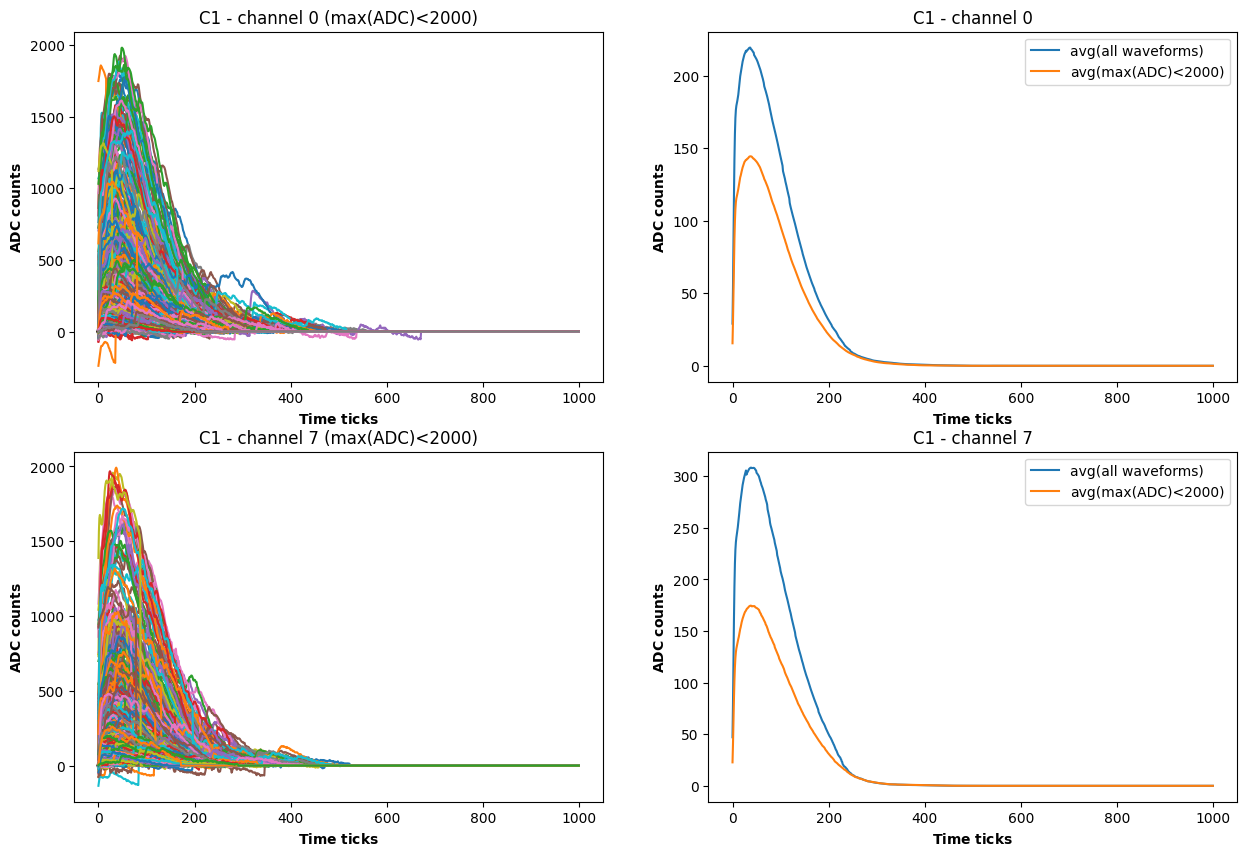

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

evts = range(0, 1000)

ADCcut = 2000

ax = axs.flatten()[0]
sel_waveforms = []
for i in range(0, len(ch0_dict['wfs_padded'])):
    wf = ch0_dict['wfs_padded'][i]
    if wf.max()<ADCcut:
        sel_waveforms.append(wf)
        ax.plot(np.arange(0, wf.shape[0], 1), wf);
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
ax.set_title(r"C1 - channel 0 (max(ADC)<2000)");

ax = axs.flatten()[1]
avg_wf_ch0_all = np.array(ch0_dict['wfs_padded']).mean(axis=0)
avg_wf_ch0 = np.array(sel_waveforms).mean(axis=0)
ax.plot(np.arange(0, 1000, 1), avg_wf_ch0_all, label='avg(all waveforms)')
ax.plot(np.arange(0, 1000, 1), avg_wf_ch0, label='avg(max(ADC)<2000)')
ax.legend()
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
ax.set_title(r"C1 - channel 0");

ax = axs.flatten()[2]
sel_waveforms = []
for i in range(0, len(ch7_dict['wfs_padded'])):
    wf = ch7_dict['wfs_padded'][i]
    if wf.max()<ADCcut:
        sel_waveforms.append(wf)
        ax.plot(np.arange(0, wf.shape[0], 1), wf);
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
ax.set_title(r"C1 - channel 7 (max(ADC)<2000)");

ax = axs.flatten()[3]
avg_wf_ch7_all = np.array(ch7_dict['wfs_padded']).mean(axis=0)
avg_wf_ch7 = np.array(sel_waveforms).mean(axis=0)
ax.plot(np.arange(0, 1000, 1), avg_wf_ch7_all, label='avg(all waveforms)')
ax.plot(np.arange(0, 1000, 1), avg_wf_ch7, label='avg(max(ADC)<2000)')
ax.legend()
ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");
ax.set_title(r"C1 - channel 7");

# Deconvolution

In [31]:
def deconvolve_waveform(waveform, det_response, regularization=1e-2):
    """
    Deconvolve a measured waveform with a known detector response.
    
    Parameters:
        waveform (np.array): The measured waveform (y)
        det_response (np.array): The known response function (h)
        regularization (float): Small constant to avoid division by zero (acts like Tikhonov regularization)
    
    Returns:
        recovered (np.array): The deconvolved signal (x)
    """
    # Pad response to match length
    n = len(waveform)
    response_padded = np.zeros(n)
    response_padded[:len(det_response)] = det_response

    # FFT
    Y = np.fft.fft(waveform)
    H = np.fft.fft(response_padded)

    # Avoid divide-by-zero and reduce noise amplification
    H_conj = np.conj(H)
    H_abs2 = H * H_conj
    X = Y * H_conj / (H_abs2 + regularization)

    # Inverse FFT to get recovered signal
    recovered = np.fft.ifft(X).real
    return recovered

In [32]:
peak_folder = '/Users/emiliebertholet/cernbox/coldbox_data/selected_waveforms'

with open(f'{peak_folder}/selection_cosmics_wlenNone_prom500.pkl', 'rb') as file:
    dic = pickle.load(file)
cosmics = pd.DataFrame(dic)
print(f"cosmics:  {cosmics.shape[0]} peaks, {cosmics.trigger_record.unique().shape[0]} trigger records")


with open(f'{peak_folder}/selection_PNS_neutrons_wlenNone_prom500.pkl', 'rb') as file:
    dic = pickle.load(file)
PNS_neutrons = pd.DataFrame(dic)
print(f"PNS_neutrons:  {PNS_neutrons.shape[0]} peaks, {PNS_neutrons.trigger_record.unique().shape[0]} trigger records")


cosmics:  25150 peaks, 4189 trigger records
PNS_neutrons:  3780 peaks, 3187 trigger records


In [33]:
def pad_waveforms(input_data, pad_length=500):
    output_data = input_data
    output_data['waveform_padded'] = [np.pad(wf, (0, pad_length - len(wf))) if len(wf) < pad_length else wf[:pad_length] for wf in output_data['waveform']]
    return output_data

cosmics      = pad_waveforms(cosmics, 500)
PNS_neutrons = pad_waveforms(PNS_neutrons, 500)

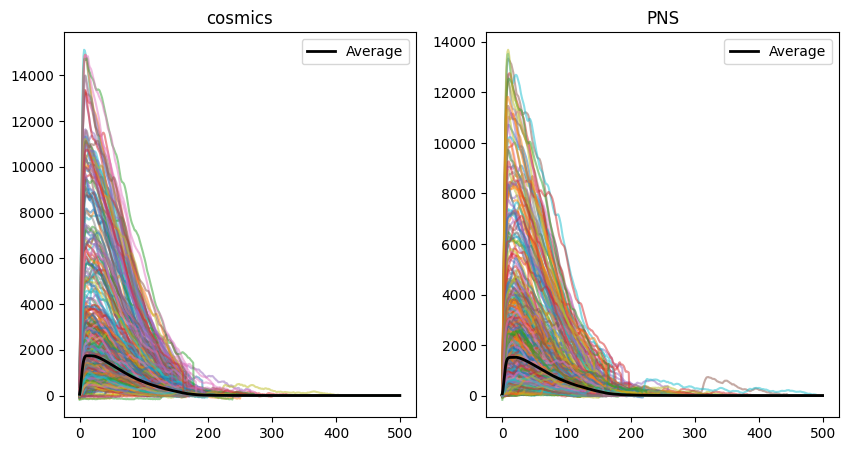

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
waveforms = np.stack(cosmics['waveform_padded'].values)
avg_cr = np.mean(cosmics['waveform_padded'], axis=0)
for w in waveforms[:1000]:
    ax.plot(w, alpha=0.5)
ax.plot(avg_cr, color='black', linewidth=2, label='Average')
ax.set_title('cosmics')
ax.legend();

ax = axs[1]
waveforms = np.stack(PNS_neutrons['waveform_padded'].values)
avg_pns = np.mean(PNS_neutrons['waveform_padded'], axis=0)
for w in waveforms[:1000]:
    ax.plot(w, alpha=0.5)
ax.plot(avg_pns, color='black', linewidth=2, label='Average')
ax.set_title('PNS')
ax.legend();



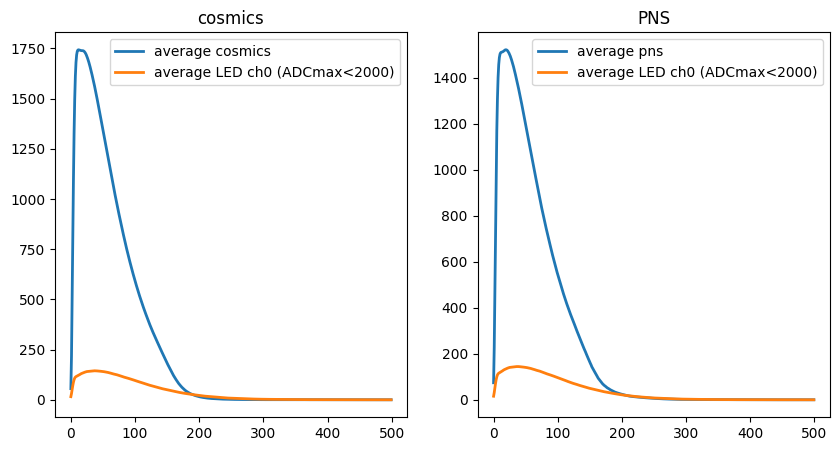

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
waveforms = np.stack(cosmics['waveform_padded'].values)
avg_cr = np.mean(cosmics['waveform_padded'], axis=0)
ax.plot(avg_cr, linewidth=2, label='average cosmics')
ax.plot(avg_wf_ch0[:500], linewidth=2, label='average LED ch0 (ADCmax<2000)')
ax.set_title('cosmics')
ax.legend();

ax = axs[1]
waveforms = np.stack(PNS_neutrons['waveform_padded'].values)
avg_pns = np.mean(PNS_neutrons['waveform_padded'], axis=0)
ax.plot(avg_pns, linewidth=2, label='average pns')
ax.plot(avg_wf_ch0[:500], linewidth=2, label='average LED ch0 (ADCmax<2000)')
ax.set_title('PNS')
ax.legend();



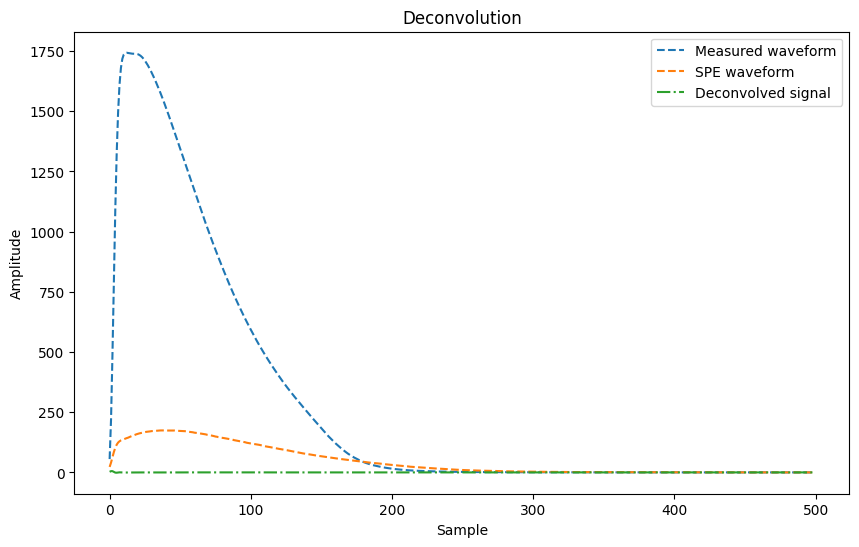

In [63]:
measured = avg_cr
det_response = avg_wf_ch7[:500]
dec = deconvolve_waveform(measured, det_response, regularization=1e-1)

# Plot
plt.figure(figsize=(10,6))
plt.plot(measured, label="Measured waveform", linestyle='--')
plt.plot(det_response, label="SPE waveform", linestyle='--')
plt.plot(dec, label="Deconvolved signal", linestyle='-.')
plt.legend()
plt.title("Deconvolution")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()